In [1]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams as rp
from imblearn.over_sampling import SMOTE

In [2]:
ohe = OneHotEncoder()
df_x = pd.read_csv('train_x_imputed.csv')

ohe_loan = ohe.fit_transform(df_x[["Loan.type"]])
df_x = df_x.join(pd.DataFrame(ohe_loan.toarray(), columns=ohe.categories_))

ohe_occ = ohe.fit_transform(df_x[["Occupation.type"]])
df_x = df_x.join(pd.DataFrame(ohe_occ.toarray(), columns=ohe.categories_))

df_x.drop(['Loan.type'],axis=1,inplace=True)
df_x.drop(['Occupation.type'],axis=1,inplace=True)
df_x.drop(['ID'],axis=1,inplace=True)
df_x.to_csv('new.csv',index=False)

In [3]:
df_x_test = pd.read_csv('test_x.csv')

ohe_loan = ohe.fit_transform(df_x_test[["Loan type"]])
df_x_test = df_x_test.join(pd.DataFrame(ohe_loan.toarray(), columns=ohe.categories_))

ohe_occ = ohe.fit_transform(df_x_test[["Occupation type"]])
df_x_test = df_x_test.join(pd.DataFrame(ohe_occ.toarray(), columns=ohe.categories_))

df_x_test.drop(['Loan type'],axis=1,inplace=True)
df_x_test.drop(['Occupation type'],axis=1,inplace=True)
df_x_test.drop(['ID_Test'],axis=1,inplace=True)
df_x_test.to_csv('X_test.csv',index=False)

In [4]:
df_x_test = pd.read_csv('test_x.csv')
arr = df_x_test.loc[:,'ID_Test'].values

In [5]:
df_x_tr = pd.read_csv('new.csv')

df_y = pd.read_csv('train_y_imputed.csv')

df_y.drop(['ID'],axis=1,inplace=True)

In [6]:
tuples_x = [tuple(x) for x in df_x_tr.values]
tuples_y = [tuple(y) for y in df_y.values]
tuples_y = np.ravel(tuples_y)

X = np.asarray(tuples_x)
y = np.asarray(tuples_y)

zeros = len([i for i in y if i == 0])
ones = len([i for i in y if i == 1])
print("zeros: ",zeros)
print("ones: ",ones)

zeros:  74695
ones:  5305


In [7]:
sm = SMOTE(random_state=42,sampling_strategy='minority')
X, y = sm.fit_resample(X, y)

In [8]:
zeros = len([i for i in y if i == 0])
ones = len([i for i in y if i == 1])
print("zeros: ",zeros)
print("ones: ",ones)

zeros:  74695
ones:  74695


In [9]:
x_train,x_val,y_train,y_val = tts(X,y,test_size=0.1,random_state=42)

In [10]:
dtrain = xgboost.DMatrix(x_train,label=y_train,feature_names=['Expense','Income','Age','Score1','Score2','Score3','Score4','Score5','A','B','X','Y','Z'])
dval = xgboost.DMatrix(x_val,label=y_val,feature_names=['Expense','Income','Age','Score1','Score2','Score3','Score4','Score5','A','B','X','Y','Z'])
evallist = [(dtrain, 'train'), (dval, 'eval')]

In [11]:
xgb = xgboost.train({'max_depth':25,'objective':'binary:logistic','gamma':10},dtrain,1000,evals=evallist,early_stopping_rounds=20)

[13:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.45668	eval-logloss:0.45990
[1]	train-logloss:0.32493	eval-logloss:0.32981
[2]	train-logloss:0.24191	eval-logloss:0.24818
[3]	train-logloss:0.18539	eval-logloss:0.19274
[4]	train-logloss:0.14636	eval-logloss:0.15384
[5]	train-logloss:0.11836	eval-logloss:0.12630
[6]	train-logloss:0.09760	eval-logloss:0.10575
[7]	train-logloss:0.08285	eval-logloss:0.09110
[8]	train-logloss:0.07203	eval-logloss:0.08044
[9]	train-logloss:0.06371	eval-logloss:0.07244
[10]	train-logloss:0.05706	eval-logloss:0.06624
[11]	train-logloss:0.05251	eval-logloss:0.06221
[12]	train-logloss:0.04877	eval-logloss:0.05834
[13]	train-logloss:0.04549	eval-logloss:0.05547
[14]	train-logloss:0.04304	e

In [12]:
y_pred_train = xgb.predict(dtrain) # This returns the probability P(Y=k|X) where k is class
y_predictions_train = (y_pred_train > 0.5).astype(int)  # Using a threshold of 0.5 we predict the class

In [14]:
y_pred = xgb.predict(dval,ntree_limit=xgb.best_ntree_limit)
y_predictions = (y_pred>0.5).astype(int)

print("Accuracy in training set is :",accuracy_score(y_predictions_train,y_train))
print("Accuracy in test set is :",accuracy_score(y_predictions,y_val))

print("Precision in training set is :",precision_score(y_predictions_train,y_train))
print("Precision in test set is :",precision_score(y_predictions,y_val))

print("Recall in training set is :",recall_score(y_predictions_train,y_train))
print("Recall in test set is :",recall_score(y_predictions,y_val))

print("F1 score in training set is :",f1_score(y_predictions_train,y_train))
print("F1 score in test set is :",f1_score(y_predictions,y_val))

Accuracy in training set is : 0.9910971283218422
Accuracy in test set is : 0.9860767119619787
Precision in training set is : 0.9883949294768791
Precision in test set is : 0.9843645596685822
Recall in training set is : 0.993762060763811
Recall in test set is : 0.9877967010862277
F1 score in training set is : 0.9910712287689932
F1 score in test set is : 0.9860776439089692


In [15]:
confusion_matrix(y_predictions_train,y_train)

array([[66822,   780],
       [  417, 66432]], dtype=int64)

In [16]:
df_x_test = pd.read_csv('X_test.csv')
tuples_x = [tuple(x) for x in df_x_test.values]
X_test = np.asarray(tuples_x)
Dtest = xgboost.DMatrix(X_test,feature_names=['Expense','Income','Age','Score1','Score2','Score3','Score4','Score5','A','B','X','Y','Z'])
Y_test_pred = xgb.predict(Dtest)
Y_test_predictions = (Y_test_pred>0.5).astype(int)
a = np.asarray(Y_test_predictions)

In [17]:
df_pred = pd.DataFrame()
df_pred.insert(0,"ID_Test",arr)
df_pred.insert(1,"Y_Predicted",a)
header = ["ID_Test","Y_Predicted"]
df_pred.to_csv('Predictions.csv',sep=',',columns=header,index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

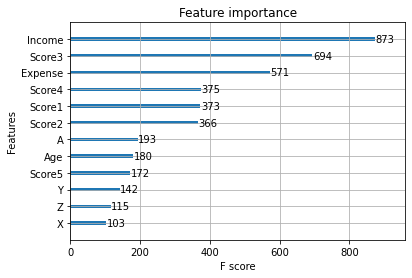

In [18]:
xgboost.plot_importance(xgb)